<a href="https://www.kaggle.com/code/dsptlp/mlclassificationtosql?scriptVersionId=168300536" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# ML Classification Into SQL
- Build Classification Model
- Extract features and build SQL Code Implementation
- SQL Code Logistic Regression Implementation:

```
SELECT
  1 / (1 + EXP(-(
    -- Intercept
    <intercept> +
    -- Coefficients for each feature
    <coef_1> * (feature_1 - <median_1>) / <iqr_1> +
    <coef_2> * (feature_2 - <median_2>) / <iqr_2> +
    -- ... Repeat for all features ...
    <coef_n> * (feature_n - <median_n>) / <iqr_n>
  ))) AS predicted_probability
FROM your_table_with_unscaled_features;
```

## Why Into SQL ?
- Database Integration: If your ML model is integrated with a database, you can perform predictions on the fly as part of SQL queries. This is useful for applications requiring low-latency predictions directly within the database system.

- Scalability: SQL databases are optimized for parallel processing. By implementing your ML model in SQL, you can take advantage of the database engine's ability to distribute computations across multiple nodes, improving scalability.

- Consistency and Standardization: Incorporating ML models into SQL databases provides a unified platform for both data storage and analysis. This can lead to easier maintenance, versioning, and deployment of models.

- Security and Access Control: Running ML models within a SQL database environment can leverage existing security features and access controls. This ensures that sensitive data is handled securely, and access is regulated according to the database security protocols.
Reduced Data Movement:

- Minimized Data Transfer: If your data is already stored in a SQL database, implementing ML models in SQL can help avoid unnecessary data movement. This is especially beneficial when dealing with large datasets, as moving data between systems can be resource-intensive.
Simplified Deployment:

- Integrated Deployment: Deploying ML models within a SQL environment can simplify the deployment process. Instead of managing separate deployment pipelines for database operations and ML models, you can have a more streamlined approach.
Compatibility with BI Tools:

- Business Intelligence (BI) Integration: SQL-based ML models can be seamlessly integrated with BI tools that rely on SQL queries. This allows for easier adoption by business analysts and other non-technical users.

- Existing Infrastructure: In organizations where SQL databases are already a fundamental part of the technology stack, implementing ML models in SQL can make better use of existing infrastructure and expertise.

# Key Features:
### Data Loading and Preprocessing:

- The script loads a heart-related dataset from a CSV file, handles missing values, and encodes categorical variables.
- Robust scaling is applied to continuous features.

### Model Training and Evaluation:

- Several classification models (e.g., AdaBoost, Logistic Regression, Random Forest, Gradient Boosting) are trained and evaluated.
- Model evaluation includes accuracy, confusion matrix, and ROC AUC. Cross-validation is implemented for more robust performance assessment.

### Hyperparameter Tuning:

- Hyperparameter tuning is performed for RandomForestClassifier and LogisticRegression using GridSearchCV.

### Feature Importance (Tree-based Models):

- For tree-based models, feature importance is extracted and displayed.

### Model Saving:

- Trained models are saved using joblib for potential deployment.


In [1]:
try:
    import imblearn
except ImportError:
    print("imbalanced-learn not found. Installing...")
    !pip install imbalanced-learn
    print("imbalanced-learn installed successfully!")

# Now import and use imbalanced-learn
from imblearn.over_sampling import RandomOverSampler

In [2]:
# Importing necessary packages
import os
import numpy as np
import pandas as pd
import logging
import warnings
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import csv

from sklearn.calibration import calibration_curve
from scikitplot.metrics import plot_precision_recall
from sklearn.metrics import precision_recall_curve, auc
from scikitplot.metrics import plot_lift_curve
from scikitplot.metrics import plot_cumulative_gain
from sklearn.metrics import classification_report, roc_curve, accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import ConvergenceWarning

import xgboost as xgb
import sqlite3


# Setting up options and ignoring warnings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('float_format', '{:f}'.format)
warnings.filterwarnings('ignore')

# Setting up logging with a FileHandler
log_file_path = 'classification_log.txt'
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', datefmt='%Y-%m-%d %H:%M:%S')

file_handler = logging.FileHandler(log_file_path)
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))

logger = logging.getLogger(__name__)
logger.addHandler(file_handler)

In [3]:
# Reading the dataset
dataset_path = "../input/heart-attack-analysis-prediction-dataset/heart.csv"

try:
    # Attempt to read the dataset
    df = pd.read_csv(dataset_path)
    logger.info(f"Dataset loaded successfully from {dataset_path}")
except FileNotFoundError:
    logger.error("Error: Dataset file not found. Please provide the correct file path.")
except Exception as e:
    logger.error(f"An error occurred: {e}")

In [4]:
# creating a copy of df
df1 = df.fillna(0)

# define the columns to be encoded and scaled
cat_cols = ['sex','exng','caa','cp','fbs','restecg','slp','thall']
con_cols = ["age","trtbps","chol","thalachh","oldpeak"]

#target column name
label_name = 'output'

# encoding the categorical columns
df1 = pd.get_dummies(df1, columns = cat_cols, drop_first = True)

# defining the features and target
X = df1.drop([label_name],axis=1)
y = df1[[label_name]]

# instantiating the scaler
scaler = RobustScaler()

# scaling the continuous featuree
X[con_cols] = scaler.fit_transform(X[con_cols])

# Get centering and scaling values for each feature
centering = scaler.center_
iqrs  = scaler.scale_

X.head()

,age,trtbps,chol,thalachh,oldpeak,sex_1,exng_1,caa_1,caa_2,caa_3,caa_4,cp_1,cp_2,cp_3,fbs_1,restecg_1,restecg_2,slp_1,slp_2,thall_1,thall_2,thall_3
0,0.592593,0.750000,-0.110236,-0.092308,0.937500,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0
1,-1.333333,0.000000,0.157480,1.046154,1.687500,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
2,-1.037037,0.000000,-0.566929,0.584615,0.375000,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0
3,0.074074,-0.500000,-0.062992,0.769231,0.000000,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0
4,0.148148,-0.500000,1.795276,0.307692,-0.125000,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0


In [5]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)
print("The shape of X_train is      ", X_train.shape)
print("The shape of X_test is       ",X_test.shape)
print("The shape of y_train is      ",y_train.shape)
print("The shape of y_test is       ",y_test.shape)

The shape of X_train is       (242, 22)
The shape of X_test is        (61, 22)
The shape of y_train is       (242, 1)
The shape of y_test is        (61, 1)


In [6]:
# Handling Class Imbalance with RandomOverSampler
ros = RandomOverSampler(sampling_strategy=0.9, random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [7]:
# Defining a dictionary of classification models
classifiers = {
    'AdaBoostClassifier': AdaBoostClassifier(),
    'LogisticRegression': LogisticRegression(random_state=9, n_jobs=-1),
    'KNeighborsClassifier': KNeighborsClassifier(n_jobs=-1),
    'RandomForestClassifier': RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1),
    'GradientBoostingClassifier': GradientBoostingClassifier(n_estimators=300, max_depth=1, subsample=0.8, max_features=0.2),
    'XGBClassifier': xgb.XGBClassifier(eval_metric='error', n_jobs=-1),
    'SVMClassifier': SVC(probability=True),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'GaussianNB': GaussianNB(),
    'MLPClassifier': MLPClassifier(),
    'ExtraTreesClassifier': ExtraTreesClassifier(n_estimators=100, random_state=0, n_jobs=-1)
}

In [8]:
print("The shape of X_train is      ", X_resampled.shape)
print("The shape of y_train is      ", y_resampled.shape)

The shape of X_train is       (252, 22)
The shape of y_train is       (252, 1)


AdaBoostClassifier CV Scores: [0.84313725 0.82352941 0.72       0.82       0.8       ]
AdaBoostClassifier Accuracy: 0.7868852459016393
AdaBoostClassifier Confusion Matrix: [[25  4]
 [ 9 23]]
AdaBoostClassifier ROC AUC: 0.8502155172413793
              precision    recall  f1-score   support

           0       0.74      0.86      0.79        29
           1       0.85      0.72      0.78        32

    accuracy                           0.79        61
   macro avg       0.79      0.79      0.79        61
weighted avg       0.80      0.79      0.79        61



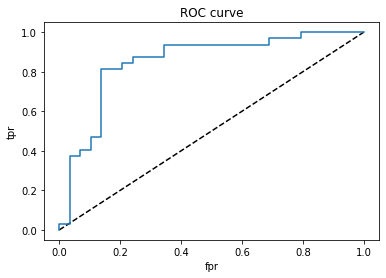

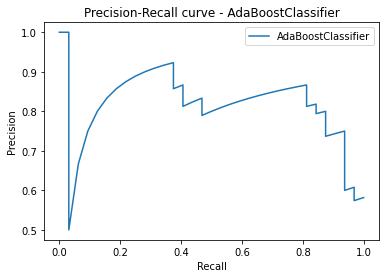

LogisticRegression CV Scores: [0.82352941 0.82352941 0.74       0.92       0.74      ]
LogisticRegression Accuracy: 0.9016393442622951
LogisticRegression Confusion Matrix: [[27  2]
 [ 4 28]]
LogisticRegression ROC AUC: 0.9385775862068966
              precision    recall  f1-score   support

           0       0.87      0.93      0.90        29
           1       0.93      0.88      0.90        32

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61



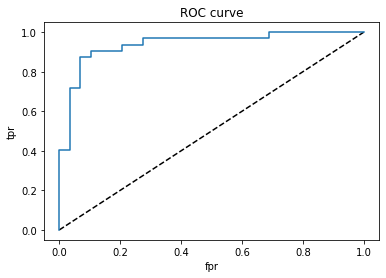

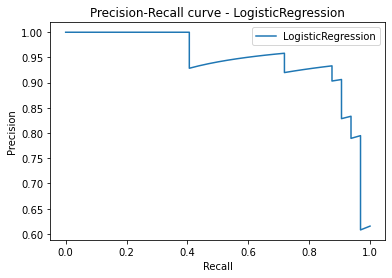

KNeighborsClassifier CV Scores: [0.78431373 0.84313725 0.74       0.86       0.78      ]
KNeighborsClassifier Accuracy: 0.8688524590163934
KNeighborsClassifier Confusion Matrix: [[25  4]
 [ 4 28]]
KNeighborsClassifier ROC AUC: 0.9342672413793103
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        29
           1       0.88      0.88      0.88        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



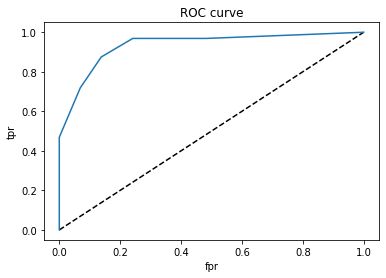

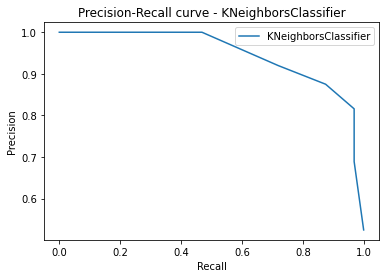

RandomForestClassifier CV Scores: [0.84313725 0.82352941 0.76       0.9        0.8       ]
RandomForestClassifier Accuracy: 0.8524590163934426
RandomForestClassifier Confusion Matrix: [[27  2]
 [ 7 25]]
RandomForestClassifier ROC AUC: 0.9380387931034482
              precision    recall  f1-score   support

           0       0.79      0.93      0.86        29
           1       0.93      0.78      0.85        32

    accuracy                           0.85        61
   macro avg       0.86      0.86      0.85        61
weighted avg       0.86      0.85      0.85        61



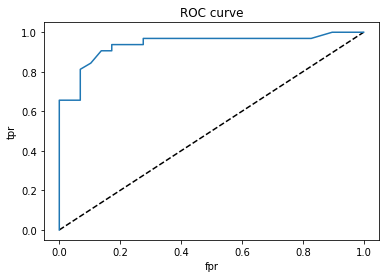

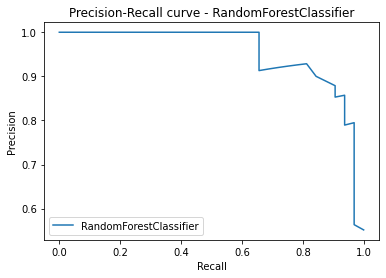

GradientBoostingClassifier CV Scores: [0.82352941 0.84313725 0.74       0.92       0.78      ]
GradientBoostingClassifier Accuracy: 0.9016393442622951
GradientBoostingClassifier Confusion Matrix: [[27  2]
 [ 4 28]]
GradientBoostingClassifier ROC AUC: 0.9127155172413793
              precision    recall  f1-score   support

           0       0.87      0.93      0.90        29
           1       0.93      0.88      0.90        32

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61



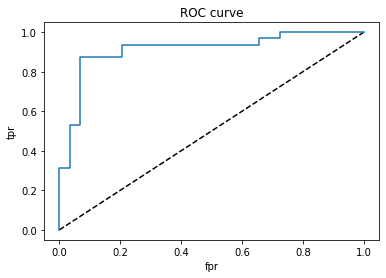

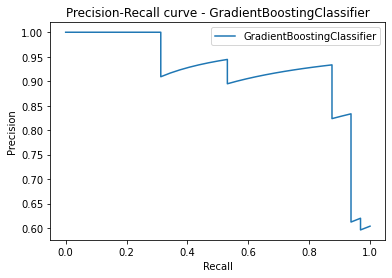

XGBClassifier CV Scores: [0.82352941 0.84313725 0.72       0.9        0.78      ]
XGBClassifier Accuracy: 0.8524590163934426
XGBClassifier Confusion Matrix: [[26  3]
 [ 6 26]]
XGBClassifier ROC AUC: 0.915948275862069
              precision    recall  f1-score   support

           0       0.81      0.90      0.85        29
           1       0.90      0.81      0.85        32

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.86      0.85      0.85        61



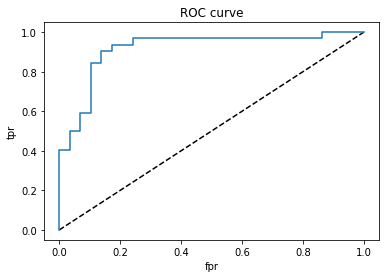

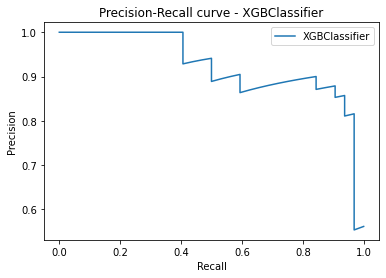

SVMClassifier CV Scores: [0.82352941 0.78431373 0.74       0.9        0.76      ]
SVMClassifier Accuracy: 0.8852459016393442
SVMClassifier Confusion Matrix: [[27  2]
 [ 5 27]]
SVMClassifier ROC AUC: 0.9321120689655172
              precision    recall  f1-score   support

           0       0.84      0.93      0.89        29
           1       0.93      0.84      0.89        32

    accuracy                           0.89        61
   macro avg       0.89      0.89      0.89        61
weighted avg       0.89      0.89      0.89        61



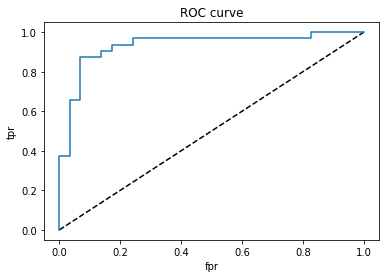

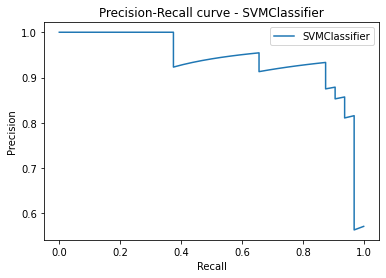

DecisionTreeClassifier CV Scores: [0.62745098 0.70588235 0.64       0.78       0.72      ]
DecisionTreeClassifier Accuracy: 0.7540983606557377
DecisionTreeClassifier Confusion Matrix: [[23  6]
 [ 9 23]]
DecisionTreeClassifier ROC AUC: 0.755926724137931
              precision    recall  f1-score   support

           0       0.72      0.79      0.75        29
           1       0.79      0.72      0.75        32

    accuracy                           0.75        61
   macro avg       0.76      0.76      0.75        61
weighted avg       0.76      0.75      0.75        61



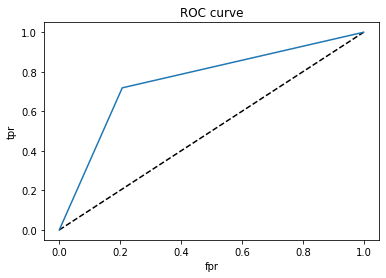

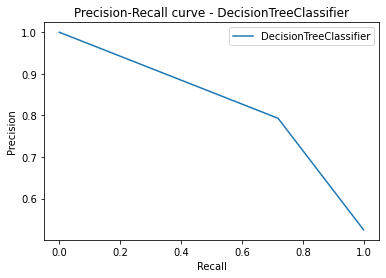

GaussianNB CV Scores: [0.76470588 0.70588235 0.66       0.76       0.66      ]
GaussianNB Accuracy: 0.6557377049180327
GaussianNB Confusion Matrix: [[28  1]
 [20 12]]
GaussianNB ROC AUC: 0.8873922413793103
              precision    recall  f1-score   support

           0       0.58      0.97      0.73        29
           1       0.92      0.38      0.53        32

    accuracy                           0.66        61
   macro avg       0.75      0.67      0.63        61
weighted avg       0.76      0.66      0.63        61



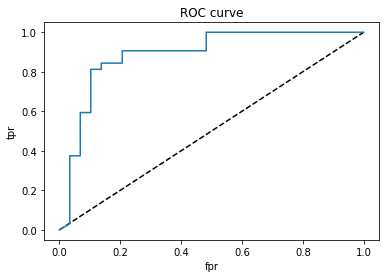

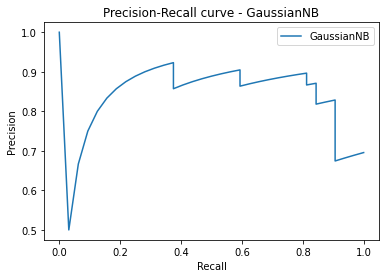

MLPClassifier CV Scores: [0.82352941 0.84313725 0.74       0.9        0.76      ]
MLPClassifier Accuracy: 0.8524590163934426
MLPClassifier Confusion Matrix: [[25  4]
 [ 5 27]]
MLPClassifier ROC AUC: 0.9234913793103449
              precision    recall  f1-score   support

           0       0.83      0.86      0.85        29
           1       0.87      0.84      0.86        32

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61



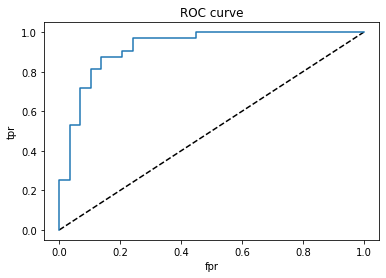

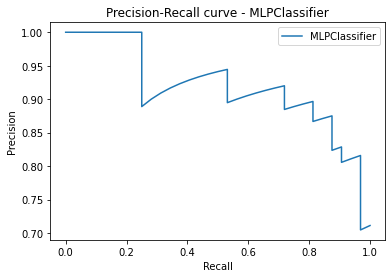

ExtraTreesClassifier CV Scores: [0.84313725 0.80392157 0.7        0.94       0.76      ]
ExtraTreesClassifier Accuracy: 0.8688524590163934
ExtraTreesClassifier Confusion Matrix: [[25  4]
 [ 4 28]]
ExtraTreesClassifier ROC AUC: 0.921875
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        29
           1       0.88      0.88      0.88        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



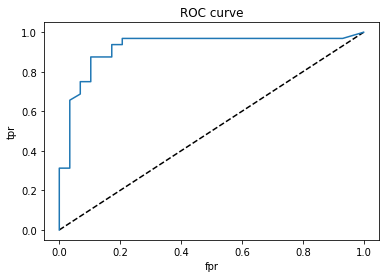

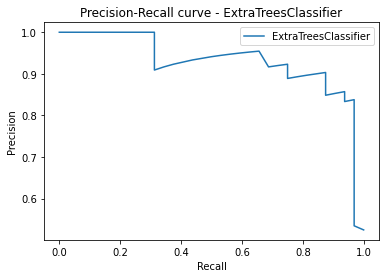

In [9]:
# Improved model evaluation and cross-validation
model_results = []

# Looping through models and evaluating their performance
for name, model in classifiers.items():
    try:
        logger.info(f"Training and evaluating {name} model.")
        
        # Cross-validation
        cv_scores = cross_val_score(model, X_resampled, y_resampled.values.ravel(), cv=5, scoring='accuracy')

        # Model training
        model.fit(X_resampled, y_resampled)
        predict = model.predict(X_test)
        acc = accuracy_score(y_test, predict)
        conf = confusion_matrix(y_test, predict)

        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        precision = precision_score(y_test, predict)
        recall = recall_score(y_test, predict)
        f1 = f1_score(y_test, predict)

        # Precision-Recall curve
        precision_recall_thresholds = precision_recall_curve(y_test, y_pred_proba)

        model_results.append({'Model': name, 'Accuracy': acc, 'ROC AUC': roc_auc, 'Precision': precision, 'Recall': recall, 'F1 Score': f1, 'CV Scores': cv_scores})
        
        print("=============================================================================")
        print(name, "CV Scores:", cv_scores)
        print(name, "Accuracy:", acc)
        print(name, "Confusion Matrix:", conf)
        print(name, "ROC AUC:", roc_auc)
        print(classification_report(y_test, predict))
        
        logger.info(f"{name} - CV Scores: {cv_scores}")
        logger.info(f"{name} - Accuracy: {acc}")
        logger.info(f"{name} - Confusion Matrix:\n{conf}")
        logger.info(f"{name} - ROC AUC: {roc_auc}")
        logger.info(f"{name} - Precision: {precision}")
        logger.info(f"{name} - Recall: {recall}")
        logger.info(f"{name} - F1 Score: {f1}")
        logger.info(classification_report(y_test, predict))

        # Plotting the ROC curve
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr, tpr, label='Knn')
        plt.xlabel('fpr')
        plt.ylabel('tpr')
        plt.title('ROC curve')
        plt.show()
        
        # Plotting the Precision-Recall curve
        plt.plot(precision_recall_thresholds[1], precision_recall_thresholds[0], label=name)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall curve - {name}')
        plt.legend()
        plt.show()
    
    except Exception as ex:
        logger.error(f"An error occurred while processing {name} model: {ex}")

### For binary classification:
- accuracy: Calculates the accuracy of the classifier.
- precision': Measures the ability of the classifier not to label as positive a sample that is negative.
- recall: Measures the ability of the classifier to capture all the positive samples.
- f1: Combines precision and recall into a single metric.
- roc_auc: Computes the area under the Receiver Operating Characteristic (ROC) curve.

In [10]:
df_results = pd.DataFrame(model_results)
df_results[['Model','Accuracy','ROC AUC','Precision','Recall','F1 Score']]

,Model,Accuracy,ROC AUC,Precision,Recall,F1 Score
0,AdaBoostClassifier,0.786885,0.850216,0.851852,0.718750,0.779661
1,LogisticRegression,0.901639,0.938578,0.933333,0.875000,0.903226
2,KNeighborsClassifier,0.868852,0.934267,0.875000,0.875000,0.875000
3,RandomForestClassifier,0.852459,0.938039,0.925926,0.781250,0.847458
4,GradientBoostingClassifier,0.901639,0.912716,0.933333,0.875000,0.903226
5,XGBClassifier,0.852459,0.915948,0.896552,0.812500,0.852459
6,SVMClassifier,0.885246,0.932112,0.931034,0.843750,0.885246
7,DecisionTreeClassifier,0.754098,0.755927,0.793103,0.718750,0.754098
8,GaussianNB,0.655738,0.887392,0.923077,0.375000,0.533333
9,MLPClassifier,0.852459,0.923491,0.870968,0.843750,0.857143


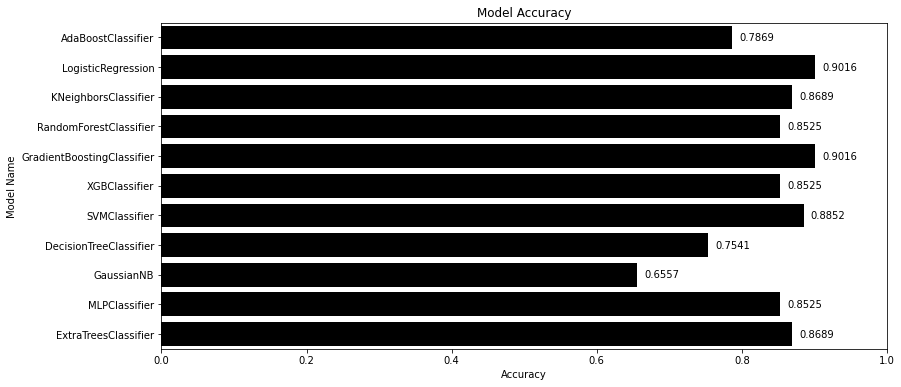

In [11]:
# Plotting
plt.figure(figsize=(13, 6))  # Adjust size as needed
ax = sns.barplot(x='Accuracy', y='Model', data=df_results,color='black')

# Adding labels and title
plt.xlabel('Accuracy')
plt.ylabel('Model Name')
plt.title('Model Accuracy')

# Adding values to the end of bars
for p in ax.patches:
    width = p.get_width()    # get bar length
    plt.text(width + 0.01,    # set the position of the text
             p.get_y() + p.get_height() / 2.,    # y-coordinate position of data label, adjusted to center the label
             f'{width:.4f}',    # data label
             ha = 'left',   # set horizontal alignment
             va = 'center', # set vertical alignment
             fontsize=10)   # font size

# Set x-axis limit
plt.xlim(0, 1)  # Adjust the limits as needed
    
# Save plot to a PNG file
plt.savefig('model_accuracy_plot.png', dpi=300, bbox_inches='tight')  

# Show plot
plt.show()

RandomForestClassifier - Feature Importance:
      Feature  Importance
4     oldpeak    0.120166
3    thalachh    0.114876
20    thall_2    0.108515
0         age    0.088052
2        chol    0.085814
1      trtbps    0.074509
21    thall_3    0.061292
6      exng_1    0.060458
7       caa_1    0.043897
5       sex_1    0.035226
18      slp_2    0.034886
12       cp_2    0.034695
17      slp_1    0.027435
8       caa_2    0.022820
15  restecg_1    0.019718
9       caa_3    0.016738
13       cp_3    0.013440
11       cp_1    0.013412
14      fbs_1    0.011630
19    thall_1    0.008561
10      caa_4    0.002553
16  restecg_2    0.001307


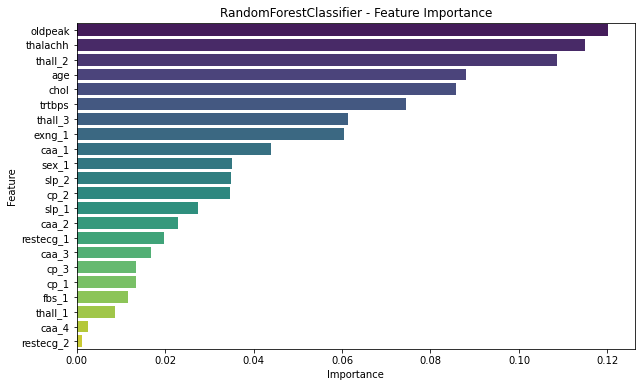

GradientBoostingClassifier - Feature Importance:
      Feature  Importance
20    thall_2    0.167106
4     oldpeak    0.109705
3    thalachh    0.105147
6      exng_1    0.083136
0         age    0.074378
7       caa_1    0.070530
21    thall_3    0.057570
12       cp_2    0.047026
8       caa_2    0.045272
2        chol    0.041075
5       sex_1    0.040724
17      slp_1    0.035392
18      slp_2    0.033830
1      trtbps    0.032409
13       cp_3    0.018783
9       caa_3    0.015522
11       cp_1    0.010061
15  restecg_1    0.005319
10      caa_4    0.004400
14      fbs_1    0.001474
19    thall_1    0.001140
16  restecg_2    0.000000


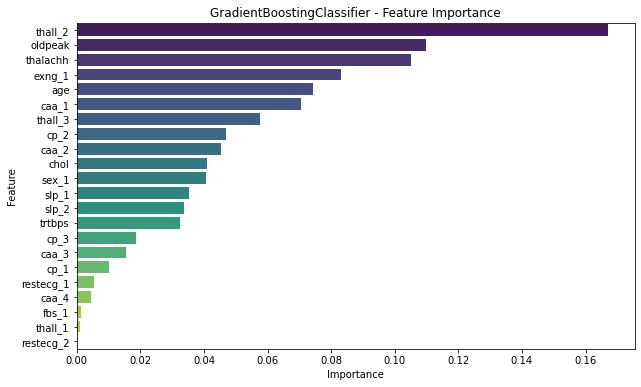

In [12]:
# Feature importance for tree-based models
for name, model in classifiers.items():
    if isinstance(model, (RandomForestClassifier, GradientBoostingClassifier)):
        model.fit(X_train, y_train)
        feature_importances = model.feature_importances_
        feature_names = X_train.columns
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
        sorted_df = importance_df.sort_values(by='Importance', ascending=False)
        
        # Print sorted feature importance
        print(f"{name} - Feature Importance:")
        print(importance_df.sort_values(by='Importance', ascending=False))
        
         # Create seaborn bar plot
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=sorted_df, palette='viridis')
        plt.title(f"{name} - Feature Importance")
        plt.show()

In [13]:
# Save trained models for deployment
for name, model in classifiers.items():
    joblib.dump(model, f"{name}_model.joblib")

## Hyperparameter Tuning RandomForest

In [14]:
# instantiating the object
model = RandomForestClassifier()

# setting a grid - not so extensive
parameters = {'n_estimators': [50, 60],
    'max_depth': [2,3,10,15,20,25, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]}

searcher = GridSearchCV(estimator = model, param_grid = parameters,cv=5, scoring='accuracy')

# fitting the object
searcher.fit(X_train, y_train)

# the scores
print("The best params are :", searcher.best_params_)
print("The best score is   :", searcher.best_score_)

# predicting the values
y_pred = searcher.predict(X_test)

# printing the test accuracy
print("The test accuracy score of model after hyper-parameter tuning is ", accuracy_score(y_test, y_pred))

The best params are : {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 60}
The best score is   : 0.822278911564626
The test accuracy score of model after hyper-parameter tuning is  0.8524590163934426


## Hyperparameter Tuning LogisticRegression

In [15]:
# instantiating the object
model = LogisticRegression()

# Define a parameter grid
parameters = {
    'C': [0.0001,0.001,0.01,0.1,1,2],  # Regularization parameter
    'penalty': ['l2','elasticnet'],       # Regularization type
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],        # Solver algorithm
    'max_iter' :[1000,2000,5000,10000],
    'class_weight': [None, 'balanced'],  # Class weights
    'multi_class': ['ovr', 'multinomial'],  # Multi-class handling
    'tol': [1e-4,1e-3,1e-2,1e-1,1],  # Tolerance
    'verbose': [0],  # Verbosity
    'warm_start': [True, False],  # Warm start
    'random_state': [42],  # Random state for reproducibility
    'n_jobs' :[-1]
}

searcher = GridSearchCV(estimator = model, param_grid = parameters, cv=3, scoring='accuracy')
searcher.fit(X_train, y_train)

# Get the parameters being tried
param_grid = searcher.param_grid
print("Parameters being tried during grid search:")
for param, values in param_grid.items():
    print(param, ":", values)

# Get the current parameter combination
results = searcher.cv_results_
current_params = {key: results['params'][results['rank_test_score'][0]-1][key] for key in parameters.keys()}
print("Current parameters being used:")
print(current_params)

# Get the best hyperparameters from the GridSearchCV
best_params = searcher.best_params_

# the scores
print("The best params are :", best_params)
print("The best score is   :", searcher.best_score_)

# predicting the values
y_pred = searcher.predict(X_test)

# printing the test accuracy
print("The test accuracy score of model after hyper-parameter tuning is ", accuracy_score(y_test, y_pred))

Parameters being tried during grid search:
C : [0.0001, 0.001, 0.01, 0.1, 1, 2]
penalty : ['l2', 'elasticnet']
solver : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
max_iter : [1000, 2000, 5000, 10000]
class_weight : [None, 'balanced']
multi_class : ['ovr', 'multinomial']
tol : [0.0001, 0.001, 0.01, 0.1, 1]
verbose : [0]
warm_start : [True, False]
random_state : [42]
n_jobs : [-1]
Current parameters being used:
{'C': 0.001, 'penalty': 'elasticnet', 'solver': 'liblinear', 'max_iter': 10000, 'class_weight': 'balanced', 'multi_class': 'multinomial', 'tol': 0.001, 'verbose': 0, 'warm_start': True, 'random_state': 42, 'n_jobs': -1}
The best params are : {'C': 0.1, 'class_weight': None, 'max_iter': 1000, 'multi_class': 'ovr', 'n_jobs': -1, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': True}
The best score is   : 0.8265946502057613
The test accuracy score of model after hyper-parameter tuning is  0.8688524590163

In [16]:
# Display results for each parameter combination
results_df = pd.DataFrame(searcher.cv_results_)
print("Grid Search Results:")
results_df.head(5)

Grid Search Results:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_max_iter,param_multi_class,param_n_jobs,param_penalty,param_random_state,param_solver,param_tol,param_verbose,param_warm_start,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.010965,0.000342,0.002176,0.000086,0.000100,None,1000,ovr,-1,l2,42,lbfgs,0.000100,0,True,"{'C': 0.0001, 'class_weight': None, 'max_iter'...",0.555556,0.543210,0.550000,0.549588,0.005048,3793
1,0.010763,0.000218,0.002119,0.000112,0.000100,None,1000,ovr,-1,l2,42,lbfgs,0.000100,0,False,"{'C': 0.0001, 'class_weight': None, 'max_iter'...",0.555556,0.543210,0.550000,0.549588,0.005048,3793
2,0.010650,0.000153,0.002168,0.000016,0.000100,None,1000,ovr,-1,l2,42,lbfgs,0.001000,0,True,"{'C': 0.0001, 'class_weight': None, 'max_iter'...",0.555556,0.543210,0.550000,0.549588,0.005048,3793
3,0.010538,0.000200,0.002062,0.000024,0.000100,None,1000,ovr,-1,l2,42,lbfgs,0.001000,0,False,"{'C': 0.0001, 'class_weight': None, 'max_iter'...",0.555556,0.543210,0.550000,0.549588,0.005048,3793
4,0.010431,0.000160,0.002154,0.000028,0.000100,None,1000,ovr,-1,l2,42,lbfgs,0.010000,0,True,"{'C': 0.0001, 'class_weight': None, 'max_iter'...",0.555556,0.543210,0.550000,0.549588,0.005048,3793


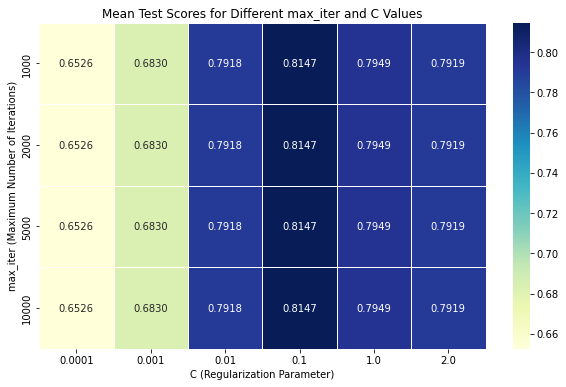

In [17]:
# Create a pivot table of mean test scores for each parameter combination
pivot_table = results_df.pivot_table(index='param_max_iter', columns='param_C', values='mean_test_score')

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', fmt=".4f", linewidths=0.5)
plt.title('Mean Test Scores for Different max_iter and C Values')
plt.xlabel('C (Regularization Parameter)')
plt.ylabel('max_iter (Maximum Number of Iterations)')
plt.show()

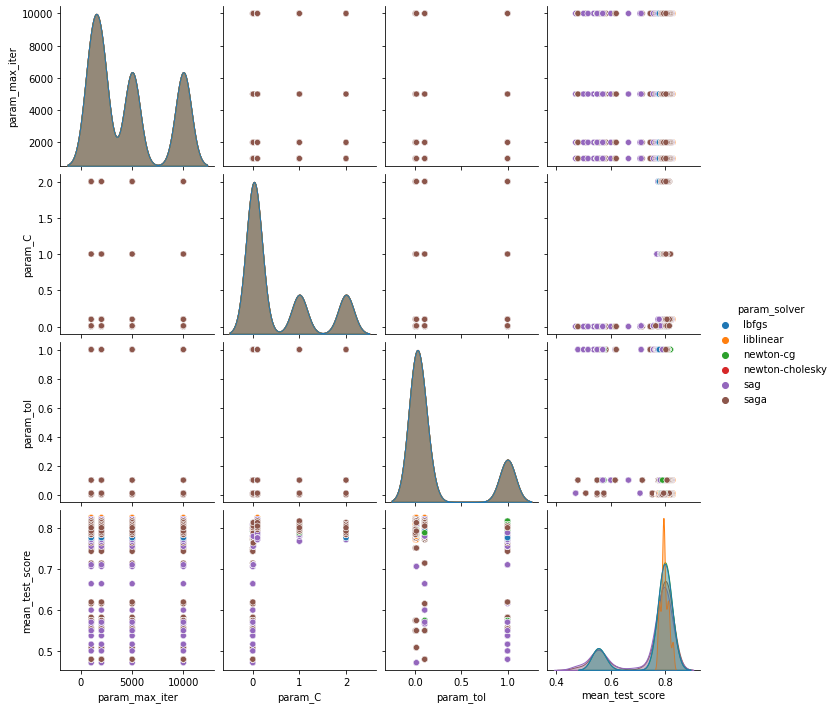

In [18]:
# Select subset of parameters for pairwise interaction plots
param_subset = ['param_max_iter', 'param_C', 'param_tol','mean_test_score']

# Create pairplot
sns.pairplot(results_df, hue='param_solver', vars=param_subset, diag_kind='kde')
plt.show()

## Train LogisticRegression Using Best Parameters

{'C': 0.1, 'class_weight': None, 'max_iter': 1000, 'multi_class': 'ovr', 'n_jobs': -1, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': True}
ExtraTreesClassifier 0.8688524590163934
[[27  2]
 [ 6 26]]
              precision    recall  f1-score   support

           0       0.82      0.93      0.87        29
           1       0.93      0.81      0.87        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.88      0.87      0.87        61



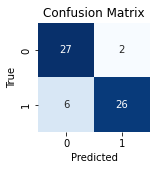

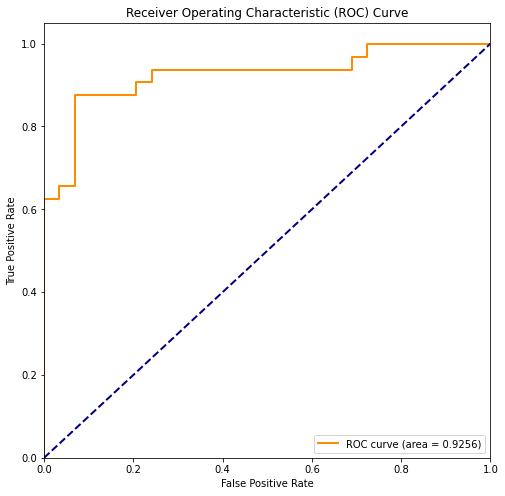

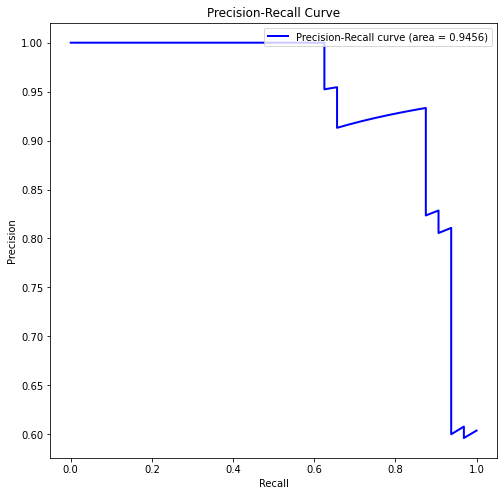

<Figure size 576x576 with 0 Axes>

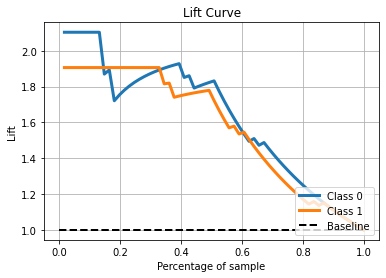

<Figure size 576x576 with 0 Axes>

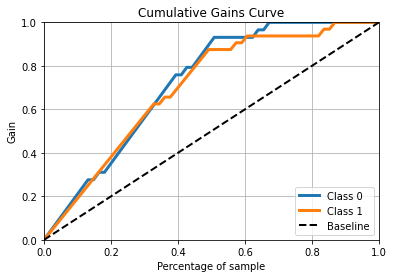

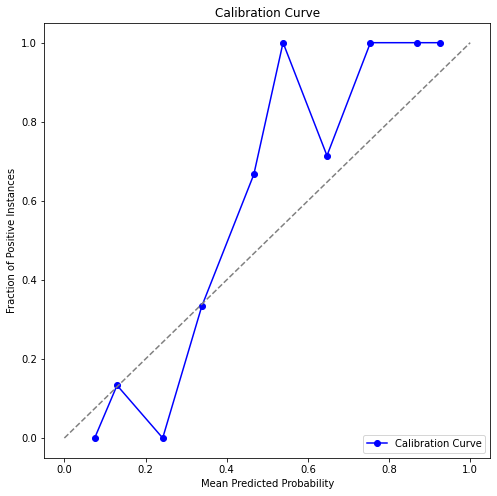

<Figure size 576x576 with 0 Axes>

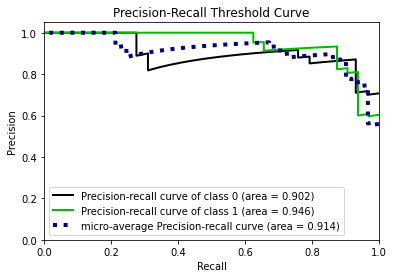

In [19]:
print(best_params)
model=LogisticRegression(**best_params)
model.fit(X_train,y_train)
predict = model.predict(X_test)
acc = accuracy_score(y_test, predict)
conf = confusion_matrix(y_test, predict)

y_pred_proba = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test,y_pred_proba)

print(name,acc)
print(conf)    
print(classification_report(y_test,predict))

# Plot Confusion Matrix
plt.figure(figsize=(2,2))
sns.heatmap(conf, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Plot ROC Curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 8))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = {:.4f})'.format(pr_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()


plt.figure(figsize=(8, 8))
plot_lift_curve(y_test, model.predict_proba(X_test))
plt.title('Lift Curve')
plt.show()

plt.figure(figsize=(8, 8))
plot_cumulative_gain(y_test, model.predict_proba(X_test))
plt.title('Cumulative Gains Curve')
plt.show()

prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)

plt.figure(figsize=(8, 8))
plt.plot(prob_pred, prob_true, marker='o', color='blue', label='Calibration Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positive Instances')
plt.title('Calibration Curve')
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(8, 8))
plot_precision_recall(y_test, model.predict_proba(X_test))
plt.title('Precision-Recall Threshold Curve')
plt.show()

Top 10 most important features:
     Feature  Coefficient  Abs_Coefficient
20   thall_2     0.633633         0.633633
12      cp_2     0.590001         0.590001
7      caa_1    -0.564721         0.564721
4    oldpeak    -0.542677         0.542677
6     exng_1    -0.492442         0.492442
8      caa_2    -0.447957         0.447957
21   thall_3    -0.431357         0.431357
5      sex_1    -0.430039         0.430039
18     slp_2     0.389817         0.389817
3   thalachh     0.381517         0.381517


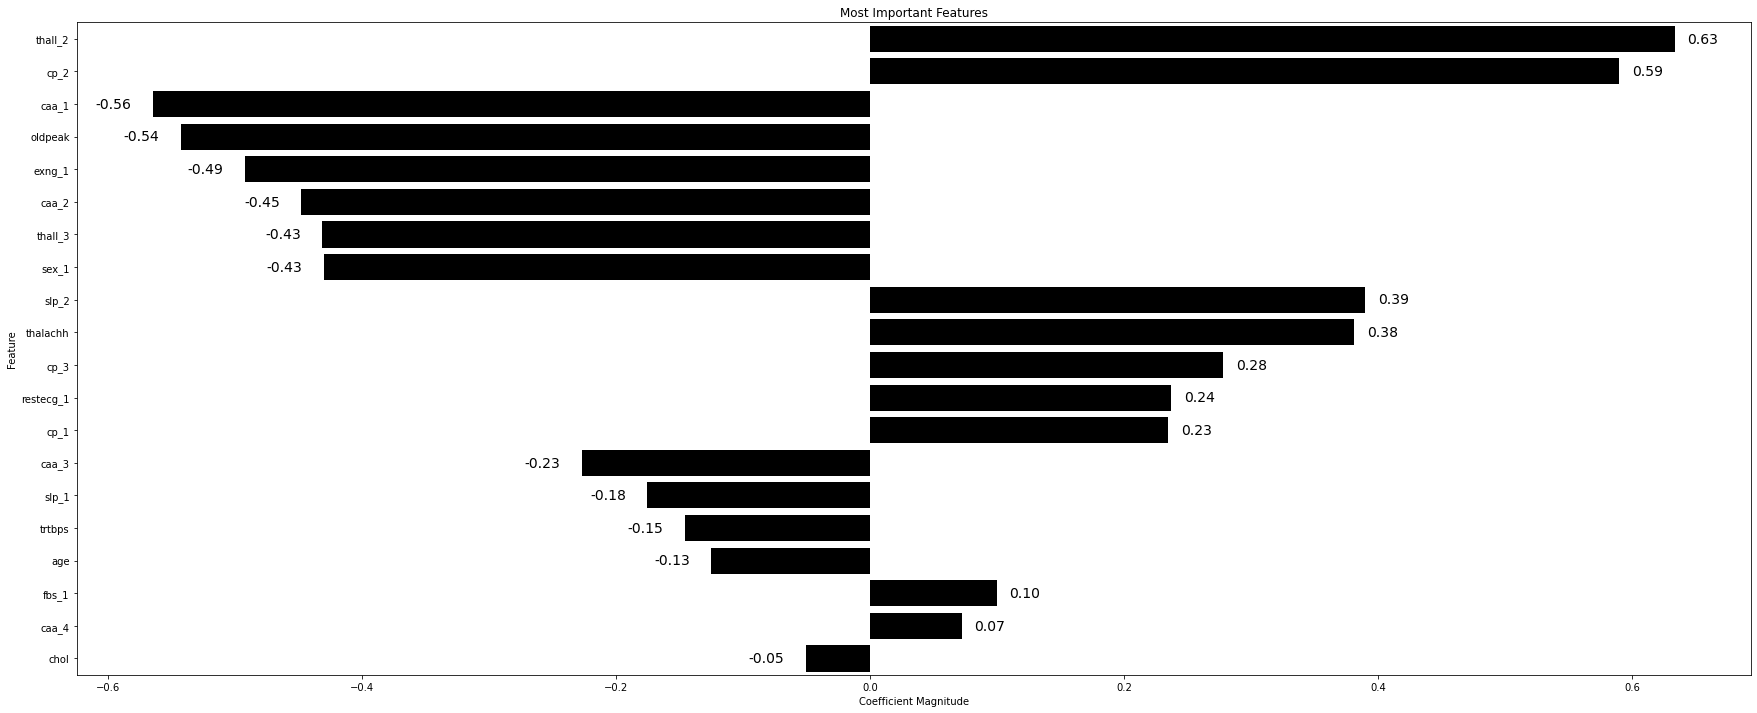

In [20]:
# Extracting coefficients and corresponding feature names
coefficients = model.coef_[0]
feature_names = X_train.columns

# Combine coefficients with feature names
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort coefficients by absolute value to identify the most important features
coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Print top features
print("Top 10 most important features:")
print(coef_df.head(10))

# Plotting
fig, ax = plt.subplots(figsize=(30, 12),frameon =False)
ax = sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(20), color='black')
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Most Important Features')

# Adding values to the end of bars
for p in ax.patches:
    val = p.get_width()
    width = p.get_width()    # get bar length
    if val > 0:
        plt.text(width + 0.01,    # set the position of the text
             p.get_y() + p.get_height() / 2.,    # y-coordinate position of data label, adjusted to center the label
             f'{width:.2f}',    # data label
             ha = 'left',   # set horizontal alignment
             va = 'center', # set vertical alignment
             fontsize=14)   # font size
    else:    
        plt.text(width - 0.045,    # set the position of the text
             p.get_y() + p.get_height() / 2.,    # y-coordinate position of data label, adjusted to center the label
             f'{width:.2f}',    # data label
             ha = 'left',   # set horizontal alignment
             va = 'center', # set vertical alignment
             fontsize=14)   # font size

plt.savefig("ML_TOP_FEATURES.png",transparent=False,  bbox_inches='tight',pad_inches=0.05,dpi=500) 
plt.show()

## LogisticRegression SQL Implementation

### MANUAL PROB CALCULATION

- Prob = 

```1 / (1 + EXP(-(
            -- Intercept
                <intercept> +
            -- Coefficients for each feature
                <coef_1> * (feature_1 - <median_1>) / <iqr_1> +
                <coef_2> * (feature_2 - <median_2>) / <iqr_2> +
                -- ... Repeat for all features ...
    <coef_n> * (feature_n - <median_n>) / <iqr_n>```

In [21]:
# Get the model coefficients
coefficients = model.coef_[0]

# Get the feature names
feature_names = X_train.columns

# Create a DataFrame to display the coefficients along with the feature names
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coefficients_list = coefficients_df.values.tolist()

# Create a DataFrame to display the Centering along with the feature names
centering_df = pd.DataFrame({'Feature': con_cols, 'centering': centering})

# Create a DataFrame to display the iqrs along with the feature names
iqrs_df = pd.DataFrame({'Feature': con_cols, 'iqrs': iqrs})

intercept = model.intercept_[0]
print('Intercept =',intercept)

# Print the DataFrames
print(coefficients_df)
print(centering_df)
print(iqrs_df)

Intercept = 0.22712658439505493
      Feature  Coefficient
0         age    -0.125065
1      trtbps    -0.145915
2        chol    -0.050723
3    thalachh     0.381517
4     oldpeak    -0.542677
5       sex_1    -0.430039
6      exng_1    -0.492442
7       caa_1    -0.564721
8       caa_2    -0.447957
9       caa_3    -0.226895
10      caa_4     0.072179
11       cp_1     0.234834
12       cp_2     0.590001
13       cp_3     0.278191
14      fbs_1     0.099845
15  restecg_1     0.237295
16  restecg_2    -0.005283
17      slp_1    -0.175452
18      slp_2     0.389817
19    thall_1    -0.000427
20    thall_2     0.633633
21    thall_3    -0.431357
    Feature  centering
0       age  55.000000
1    trtbps 130.000000
2      chol 240.000000
3  thalachh 153.000000
4   oldpeak   0.800000
    Feature      iqrs
0       age 13.500000
1    trtbps 20.000000
2      chol 63.500000
3  thalachh 32.500000
4   oldpeak  1.600000


In [22]:
column_idx = 0
calc_cols = []

X1 = df1.copy(deep=True)
X1 = X1.drop([label_name],axis=1)

for column_name, column_data in X1.iteritems():
        
    if len(centering) > column_idx:
        centering_val = centering[column_idx]
    else:
        centering_val = 0
    
    if len(iqrs) > column_idx:
        irqs_val = iqrs[column_idx]
    else: 
        irqs_val = 1
                
    X1['_calc_' + column_name] = coefficients_df.loc[column_idx][1] * (column_data - centering_val ) / irqs_val
    calc_cols.append('_calc_' + column_name)
    column_idx = column_idx + 1

# Adding specified columns together
X1['prob_Manual'] = (1/(1+np.exp(-(X1[calc_cols].sum(axis=1) + intercept))))   

In [23]:
df1_Scored = df1.copy(deep=True)
df1_Scored['prob_Manual'] =             1/(1+np.exp(-(intercept +  \
                                        coefficients_list[0][1] * (df1_Scored[coefficients_list[0][0]] - centering[0] ) / iqrs[0] + \
                                        coefficients_list[1][1] * (df1_Scored[coefficients_list[1][0]] - centering[1] ) / iqrs[1] + \
                                        coefficients_list[2][1] * (df1_Scored[coefficients_list[2][0]] - centering[2] ) / iqrs[2] + \
                                        coefficients_list[3][1] * (df1_Scored[coefficients_list[3][0]] - centering[3] ) / iqrs[3] + \
                                        coefficients_list[4][1] * (df1_Scored[coefficients_list[4][0]] - centering[4] ) / iqrs[4] + \
                                        coefficients_list[5][1] * (df1_Scored[coefficients_list[5][0]]) +  \
                                        coefficients_list[6][1] * (df1_Scored[coefficients_list[6][0]]) +  \
                                        coefficients_list[7][1] * (df1_Scored[coefficients_list[7][0]]) +  \
                                        coefficients_list[8][1] * (df1_Scored[coefficients_list[8][0]]) +  \
                                        coefficients_list[9][1] * (df1_Scored[coefficients_list[9][0]]) +  \
                                        coefficients_list[10][1] * (df1_Scored[coefficients_list[10][0]]) +  \
                                        coefficients_list[11][1] * (df1_Scored[coefficients_list[11][0]]) +  \
                                        coefficients_list[12][1] * (df1_Scored[coefficients_list[12][0]]) +  \
                                        coefficients_list[13][1] * (df1_Scored[coefficients_list[13][0]]) +  \
                                        coefficients_list[14][1] * (df1_Scored[coefficients_list[14][0]]) +  \
                                        coefficients_list[15][1] * (df1_Scored[coefficients_list[15][0]]) +  \
                                        coefficients_list[16][1] * (df1_Scored[coefficients_list[16][0]]) +  \
                                        coefficients_list[17][1] * (df1_Scored[coefficients_list[17][0]]) +  \
                                        coefficients_list[18][1] * (df1_Scored[coefficients_list[18][0]]) +  \
                                        coefficients_list[19][1] * (df1_Scored[coefficients_list[19][0]]) +  \
                                        coefficients_list[20][1] * (df1_Scored[coefficients_list[20][0]]) +  \
                                        coefficients_list[21][1] * (df1_Scored[coefficients_list[21][0]]) +  \
                                                      0 )))
                                                                                              

In [24]:
roc_auc = roc_auc_score(df1_Scored['output'],df1_Scored['prob_Manual'])
print(roc_auc)

roc_auc = roc_auc_score(df1_Scored['output'],X1['prob_Manual'])
print(roc_auc)

0.9195871761089152
0.9195871761089152


## SQL IMPLEMENTATION
- For SQL Implementation we not only need to scale the features but also implement dummy variables
- End Result we need code like this:
- 
```
SELECT
  1 / (1 + EXP(-(
    -- Intercept
    <intercept> +
    -- Coefficients for each feature
    <coef_1> * (feature_1 - <median_1>) / <iqr_1> +
    <coef_2> * (feature_2 - <median_2>) / <iqr_2> +
    -- ... Repeat for all features ...
    <coef_n> * (feature_n - <median_n>) / <iqr_n>
  ))) AS predicted_probability
FROM your_table_with_unscaled_features;
```

In [25]:
def lookup_col(df,cols):    
    key_dict = {}
    
    for col_name in cols:
        val_list = df[col_name].unique()
        for value in val_list:
            key_dict[str(col_name)+'_'+str(value)] = [col_name,value]
        
    return key_dict 

In [26]:
def generate_sql_case(key_dict,key,coefficients):
    sql_string = "CASE when " + str(key_dict[key][0]) + " = '" + str(key_dict[key][1]) + "' THEN " + coefficients + "  ELSE 0 END"
    return sql_string

In [27]:
key_dict = lookup_col(df,cat_cols)   

sql_table_name = 'heart'
score_column_name = 'man_prob'

S1 = df1.copy(deep=True)
S1 = S1.drop([label_name],axis=1)

SQL = "Select 1 / (1 + EXP(-( \n" 
column_idx = 0
calc_cols = []

for column_name, column_data in S1.iteritems():
    
    if len(centering) > column_idx:
        centering_val = str(centering[column_idx])
    else:
        centering_val = '0'
    
    if len(iqrs) > column_idx:
        irqs_val = str(iqrs[column_idx])
    else: 
        irqs_val = '1'
    
    if column_name in key_dict:
        case = generate_sql_case(key_dict,column_name,str(coefficients_df.loc[column_idx][1]))
        SQL = SQL + case + " +\n"
    else:  
        SQL = SQL + str(coefficients_df.loc[column_idx][1]) + " * (" +column_name + " - "+centering_val +") / " + irqs_val + " +\n"
    
    column_idx = column_idx + 1

SQL = SQL + str(intercept) + "  ) )) "+score_column_name+ ",* \nfrom " + sql_table_name

## FINAL SQL CODE IMPLEMENTATION

In [28]:
print(SQL)

Select 1 / (1 + EXP(-( 
-0.1250649593786283 * (age - 55.0) / 13.5 +
-0.1459149366212292 * (trtbps - 130.0) / 20.0 +
-0.05072267187042051 * (chol - 240.0) / 63.5 +
0.3815169199696786 * (thalachh - 153.0) / 32.5 +
-0.5426774359074124 * (oldpeak - 0.8) / 1.6 +
CASE when sex = '1' THEN -0.4300391313118339  ELSE 0 END +
CASE when exng = '1' THEN -0.49244224155954835  ELSE 0 END +
CASE when caa = '1' THEN -0.5647206040893832  ELSE 0 END +
CASE when caa = '2' THEN -0.447956795697951  ELSE 0 END +
CASE when caa = '3' THEN -0.22689455399742503  ELSE 0 END +
CASE when caa = '4' THEN 0.07217854576909659  ELSE 0 END +
CASE when cp = '1' THEN 0.2348338554745858  ELSE 0 END +
CASE when cp = '2' THEN 0.5900011029589133  ELSE 0 END +
CASE when cp = '3' THEN 0.2781913676839798  ELSE 0 END +
CASE when fbs = '1' THEN 0.09984545234816337  ELSE 0 END +
CASE when restecg = '1' THEN 0.23729512217834534  ELSE 0 END +
CASE when restecg = '2' THEN -0.005283339275683785  ELSE 0 END +
CASE when slp = '1' THEN -0.

# SQL IMPLEMENTATION USING SQLITE

In [29]:
# Connect to the SQLite database (creates a new database if it doesn't exist)
conn = sqlite3.connect('heart.db')

# Create a cursor object to execute SQL queries
cursor = conn.cursor()

# Create a table 
cursor.execute('''
    CREATE TABLE IF NOT EXISTS heart (
        id INTEGER PRIMARY KEY,
        age INTEGER NOT NULL,
        sex INTEGER NOT NULL,
        cp  INTEGER NOT NULL,
        trtbps  INTEGER NOT NULL,
        chol  INTEGER NOT NULL,
        fbs  INTEGER NOT NULL,
        restecg  INTEGER NOT NULL,
        thalachh  INTEGER NOT NULL,
        exng  INTEGER NOT NULL,
        oldpeak  INTEGER NOT NULL,
        slp  INTEGER NOT NULL,
        caa  INTEGER NOT NULL,
        thall  INTEGER NOT NULL,
        output  INTEGER NOT NULL
    )
''')

# Open the CSV file and insert its data into the database
with open(dataset_path, 'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    next(csv_reader)  # Skip the header row if it exists

    for row in csv_reader:
        cursor.execute('''INSERT INTO heart (age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output) VALUES (?, ?, ?,?,?,?,?,?,?,?,?,?,?,?)      ''', row)

# Commit the changes to the database
conn.commit()

# Close the cursor and connection
cursor.close()
conn.close()

In [30]:
# Connect to the SQLite database
conn = sqlite3.connect('heart.db')

# Create a cursor object to execute SQL queries
cursor = conn.cursor()

# Example SELECT query
cursor.execute("SELECT * FROM heart WHERE age > 50")

# Fetch the results
rows = cursor.fetchall()

# Get the column names from the cursor description
column_names = [description[0] for description in cursor.description]

# Create a Pandas DataFrame with the results and column names
sql_df = pd.DataFrame(rows, columns=column_names)

# Close the cursor and connection
cursor.close()

# Print the DataFrame
sql_df.head(5)

,id,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,1,63,1,3,145,233,1,0,150,0,2.300000,0,0,1,1
1,4,56,1,1,120,236,0,1,178,0,0.800000,2,0,2,1
2,5,57,0,0,120,354,0,1,163,1,0.600000,2,0,2,1
3,6,57,1,0,140,192,0,1,148,0,0.400000,1,0,1,1
4,7,56,0,1,140,294,0,0,153,0,1.300000,1,0,2,1


In [31]:
# Connect to the SQLite database
conn = sqlite3.connect('heart.db')

# Create a cursor object to execute SQL queries
cursor = conn.cursor()

# EXECUTE our Scoring SQL
cursor.execute(SQL)

# Fetch the results
rows = cursor.fetchall()

# Get the column names from the cursor description
column_names = [description[0] for description in cursor.description]

# Create a Pandas DataFrame with the results and column names
sql_df = pd.DataFrame(rows, columns=column_names)

# Close the cursor and connection
cursor.close()

# Print the DataFrame
sql_df.head(5)

,man_prob,id,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,0.366506,1,63,1,3,145,233,1,0,150,0,2.300000,0,0,1,1
1,0.710978,2,37,1,2,130,250,0,1,187,0,3.500000,0,0,2,1
2,0.840694,3,41,0,1,130,204,0,0,172,0,1.400000,2,0,2,1
3,0.839300,4,56,1,1,120,236,0,1,178,0,0.800000,2,0,2,1
4,0.758417,5,57,0,0,120,354,0,1,163,1,0.600000,2,0,2,1


In [32]:
sql_df['round_prob'] = round(sql_df['man_prob'],1)
df = sql_df.groupby('round_prob')['output'].agg(['mean', 'count']).reset_index()
df['mean'] = df['mean'] * 100
df

,round_prob,mean,count
0,0.000000,0.000000,1
1,0.100000,4.166667,48
2,0.200000,0.000000,25
3,0.300000,25.000000,28
4,0.400000,37.037037,27
5,0.500000,52.631579,19
6,0.600000,68.181818,22
7,0.700000,80.952381,42
8,0.800000,94.871795,39
9,0.900000,96.078431,51


## PROB GRAPH

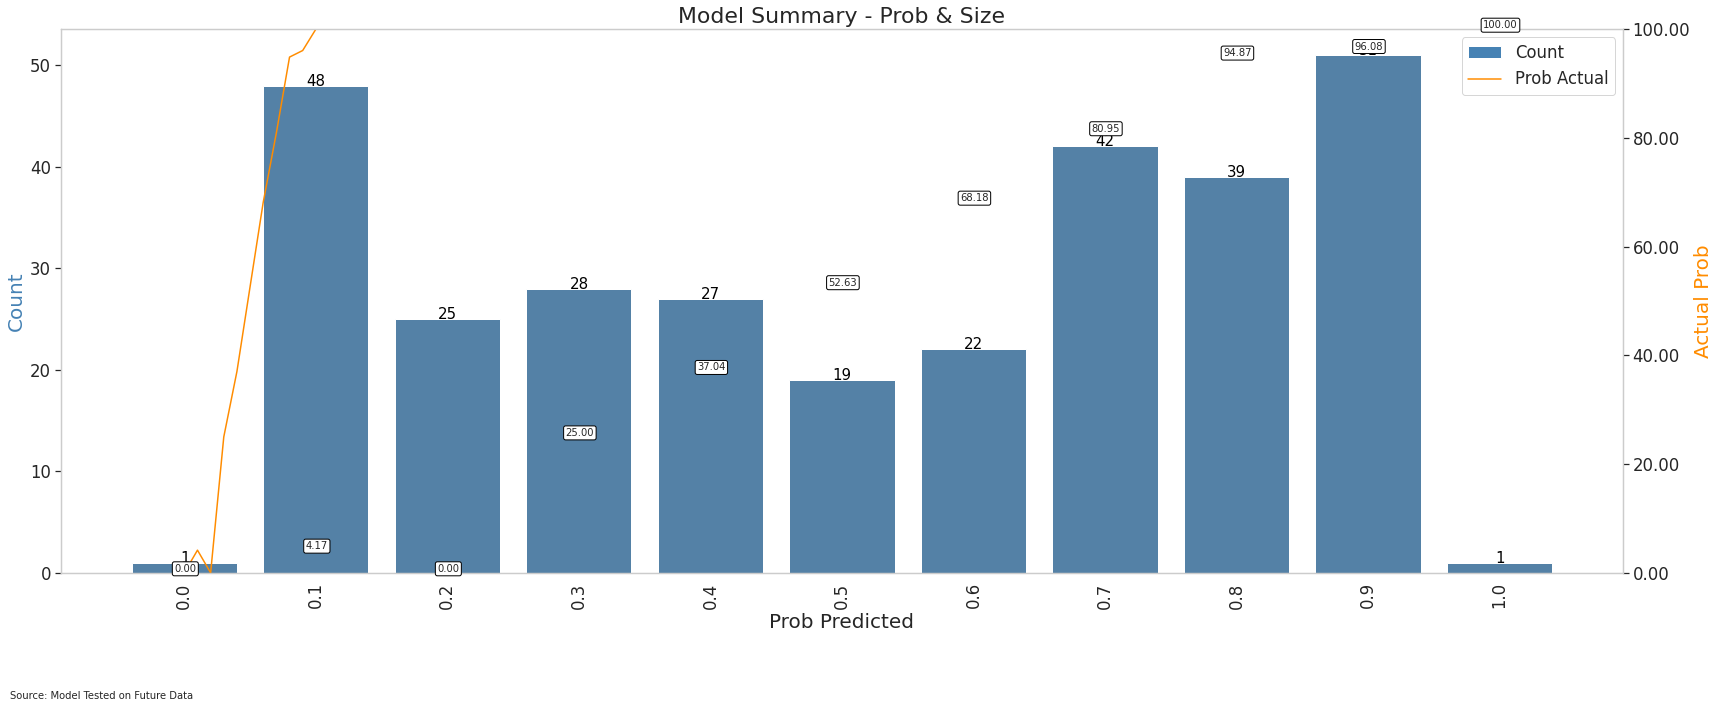

In [33]:
from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
from matplotlib import cm
import matplotlib
from matplotlib import ticker
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mtick
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

sql_df['round_prob'] = round(sql_df['man_prob'],1)
df = sql_df.groupby('round_prob')['output'].agg(['mean', 'count']).reset_index()
df['mean'] = df['mean'] * 100
df

sns.set(style="whitegrid", font_scale=1.5)

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(28, 10),frameon =False)

# Plot the bar chart on the primary y-axis
bar = sns.barplot(data=df, x='round_prob', y='count', ax=ax1, color='steelblue')
ax1.set_ylabel('Count', color='steelblue', fontsize=20)

# Add values on top of the bars
for i, v in enumerate(df['count']):
    ax1.text(i + 0.002, v + 0.002, '{:,.0f}'.format(v), color='black', ha='center',fontsize=15)

plt.xticks(rotation=90) 
ax2 = ax1.twinx()

# Plot the line chart on the secondary y-axis
line = sns.lineplot(data = df, x='round_prob', y='mean', ax=ax2, color='darkorange')
ax2.set_ylim([0, 100])
ax2.set_ylabel('Actual Prob', color='darkorange', fontsize=20)
ax2.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x)))

skip_count = 0  # Specify how many labels to skip
skip_label = 0  # Initialize skip_label counter

# Add values on top of the bars
for i, v in enumerate(df['mean']):
    if skip_label == 0:
        ax2.annotate(f'{v:,.2f}', xy=(i, v), xytext=(1, 1), ha='center', textcoords='offset points',bbox=dict(boxstyle='round,pad=0.2', edgecolor='black', facecolor='white'),fontsize=10) 
    
    skip_label = (skip_label + 1) % (skip_count + 1)    

# Set x-axis label and title
ax1.set_xlabel('Prob Predicted', fontsize=20)
ax1.set_title('Model Summary - Prob & Size', fontsize=22)
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

# Create legend with proxy artists
legend_labels = ['Count', 'Prob Actual']
legend_elements = [Patch(facecolor='steelblue', label='Bar Plot'),
                   Line2D([0], [0], color='darkorange', label='Line Plot')]
plt.legend(handles=legend_elements, labels=legend_labels)

# Disable the background grid lines
ax1.grid(False)
ax2.grid(False)

# Adding a footnote below the x-axis
footnote_text = "Source: Model Tested on Future Data"
plt.figtext(0.1, -0.05, footnote_text, ha="left", fontsize=10, bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.3'))    

# Show the plot
plt.savefig("Prob_Size.png",transparent=True,bbox_inches='tight',pad_inches=0.05,dpi=400) 
plt.show()

# END

In [34]:
# Save log messages to a file
# File handling: close the FileHandler
file_handler.close()
logger.removeHandler(file_handler)